In [ ]:
## Run if you dont have "much-data-50-50-20_2.npy"
## Code to create "much-data-50-50-20_2.npy" using "muchdata-50-50-20.npy" and stage1_labels.csv
## Must be run on "muchdata-50-50-20.npy"
import numpy as np
import pandas as pd

IMG_PX_SIZE = 50
IMG_PX_SIZE = 50
HM_SLICES = 20
########################3Change Addresses here#####################################    
###################################################################################    
much_data = np.load('lessdata-50-50-20.npy')
labels_df = pd.read_csv('D:/stage1_labels.csv',index_col=0)
###################################################################################
temp = []
for i in range(len(labels_df)):
    temp.append([much_data[i][0],much_data[i][1],labels_df.index[i]])
    
print(len(labels_df))
np.save('muchdata-{}-{}-{}_2.npy'.format(IMG_PX_SIZE,IMG_PX_SIZE, HM_SLICES),temp)

In [1]:
## Dont run unless you have "much-data-50-50-20_2.npy"
## CNN which creates the "Output.csv" containing the predicted value for patients and original values
## Must be run on "much-data-50-50-20_2.npy"
import tensorflow as tf
import numpy as np
import csv
import pandas as pd

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output
#######################################These values are needed to be changed#################################
#############################################################################################################
# must be canged to use "muchdata-50-50-20_2.npy""
much_data = np.load('lessdata-50-50-20.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
# Depends upon how much tarining data you want
#train_data = much_data[:-100]
#validation_data = much_data[-100:]

train_data = much_data[0:10]
validation_data = much_data[10:15]
#to Store final Results in csv
##############################################################################################################
#Var to store Result for later use in output.csv
Result=[]

def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 1
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                print(total_runs)
                try:
                    X = data[0]# Actual Reduced image form much date
                    Y = data[1]# [0,1] or [1,0] cancer or not cancer form much data
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
                       
            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
           
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))

            #array = tf.argmax(perdiction, 1)
            #print("Array",array.eval(feed_dict={x:[i[0] for i in validation_data]}, session=sess))

        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        print('fitment percent:',successful_runs/total_runs)
        
        #Storing the Values for Future use
        array=sess.run(correct,feed_dict={x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]})

        for i in range(len(validation_data)):
            if(validation_data[i][1][0]==1):
                Result.append([validation_data[i][2],0,array[i]])
            else:
                Result.append([validation_data[i][2],1,array[i]])
            

# Run this locally:
# train_neural_network(x)

train_neural_network(x)


## Writes Result to "Output.csv"
a= pd.DataFrame(Result,columns=['id','cancer','result'])
print(a)
a.to_csv('output.csv')

ModuleNotFoundError: No module named 'tensorflow'

In [15]:
###########Testing Dont bother#################

[['013395589c01aa01f8df81d80fb0e2b8', 0, False], ['01de8323fa065a8963533c4a86f2f6c1', 0, False], ['01e349d34c06410e1da273add27be25c', 0, False], ['01f1140c8e951e2a921b61c9a7e782c2', 0, False], ['024efb7a1e67dc820eb61cbdaa090166', 0, False]]
                                 ID  Cancer  Result
0  013395589c01aa01f8df81d80fb0e2b8       0   False
1  01de8323fa065a8963533c4a86f2f6c1       0   False
2  01e349d34c06410e1da273add27be25c       0   False
3  01f1140c8e951e2a921b61c9a7e782c2       0   False
4  024efb7a1e67dc820eb61cbdaa090166       0   False


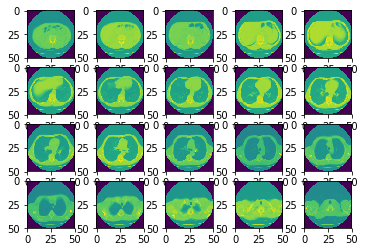

In [20]:
#########################3Testing Dont be bothered################
import matplotlib.pyplot as plt
fig =  plt.figure()
for num,each in enumerate(much_data[0][0]):
    y= fig.add_subplot(4,5,num+1)
    plt.imshow(each)
plt.show()

In [29]:
#####################################Testing Dont Bother########################
print(temp[0][2])

0015ceb851d7251b8f399e39779d1e7d
